In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table , join
from mocpy import MOC
from astropy.io import fits
from astropy import wcs
import seaborn as sns



/home/mc741/anaconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. The prior for XID+ is based on IRAC detected sources coming from SWIRE.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_Bootes/data/holes_Bootes_irac_i1_O16_20180424.fits')
_MOC=pymoc.MOC()
_MOC.read('./data/Bootes_PACS100_v0-1-_MOC.fits')

In [3]:
Final=Sel_func.intersection(_MOC)
Final.write('./data/testMoc.fits', overwrite=True)

## Read in XID+MIPS catalogue

In [4]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_Bootes/data/dmu26_XID+MIPS_Bootes_cat_20190320.fits')

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J142532.010+323934.707,216.383375208803,32.6596409059389,3.432481,8.387222,0.89181817,-0.0013047275,4.913415e-06,0.9986426,2000.0,0.0,True
HELP_J142532.800+323945.723,216.38666555616197,32.662700727634004,-39.001587,-25.958603,-53.792427,-0.0013047275,4.913415e-06,1.0025071,2000.0,0.0,True
HELP_J142533.193+323941.822,216.38830235616197,32.661617327634,-29.605513,-15.073171,-44.363415,-0.0013047275,4.913415e-06,1.0059888,776.0,0.0,True
HELP_J142535.865+323854.257,216.3994360921625,32.64840483834955,19.40917,33.105164,7.6843433,-0.0013047275,4.913415e-06,1.0001347,1096.0,0.0,True
HELP_J142540.861+324026.226,216.42025485616196,32.673951727634,18.31059,33.506855,6.543136,-0.0020661626,5.005267e-06,1.0009118,2000.0,0.0,True
HELP_J142541.339+323925.955,216.42224695616198,32.657209627634,-6.903529,-1.9368844,-15.973758,-0.0020661626,5.005267e-06,1.0005563,2000.0,0.0,True
HELP_J142540.401+323948.506,216.41833815616198,32.663473927634,-12.98247,-4.0506277,-26.492723,-0.0020661626,5.005267e-06,1.0003942,2000.0,0.0,True
HELP_J142538.888+324021.250,216.41203535616197,32.672569527634,-3.1099455,-0.7689666,-7.426327,-0.0020661626,5.005267e-06,0.999253,2000.0,0.0,True


4.9971194
5068


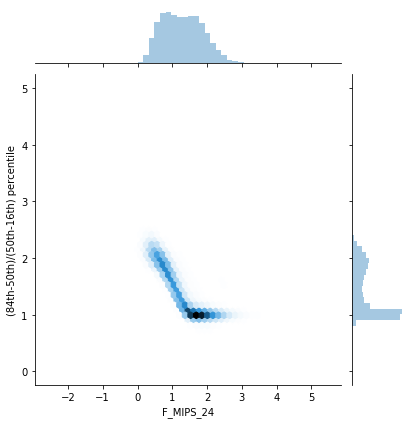

In [7]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))


The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [8]:
good=XID_MIPS['F_MIPS_24']>20

In [9]:
good.sum()

495159

## Read in Maps

In [10]:
im100fits='../../dmu18/dmu18_HELP-PACS-maps/data/Bootes_PACS100_v0.9.fits'#PACS 100 map
im160fits='../../dmu18/dmu18_HELP-PACS-maps/data/Bootes_PACS160_v0.9.fits'#PACS 160 map

#output folder
output_folder='./'

In [11]:
from astropy.io import fits
from astropy import wcs


#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100hdu=hdulist['IMAGE'].header
im100=hdulist['IMAGE'].data
w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160hdu=hdulist['IMAGE'].header
im160=hdulist['IMAGE'].data
w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data

hdulist.close()


In [12]:
np.shape(im100)

(6868, 6682)

## Read in PSF

In [20]:
pacs100_psf=fits.open('../../dmu18/dmu18_Bootes/data/dmu18_PACS_100_PSF_Bootes_20190125.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_Bootes/data/dmu18_PACS_160_PSF_Bootes_20190125.fits')

print (pacs100_psf)
centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=15

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map




[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f1ced71d278>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f1cf70d1a58>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f1cf7075668>]


In [21]:
print(pind160)

[ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.          8.33333333  8.66666667  9.          9.33333333  9.66666667
 10.        ]


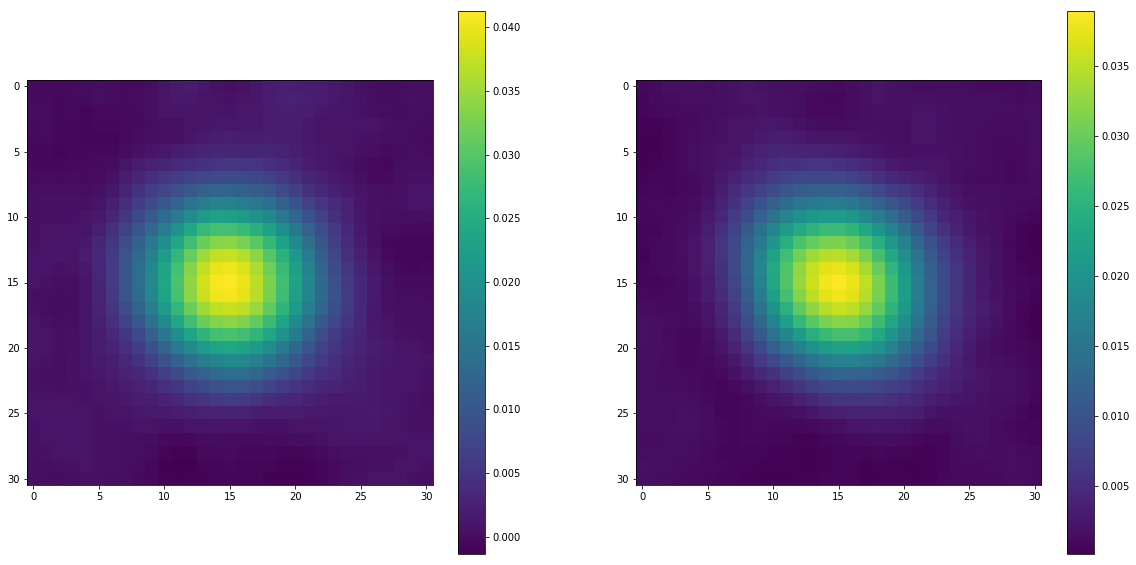

In [22]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()


## Set XID+ prior class

In [23]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_Bootes_cat_20190325.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Final)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_Bootes_cat_20190325.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


([<aplpy.core.FITSFigure at 0x7f1ced5de390>],
 <Figure size 720x720 with 2 Axes>)

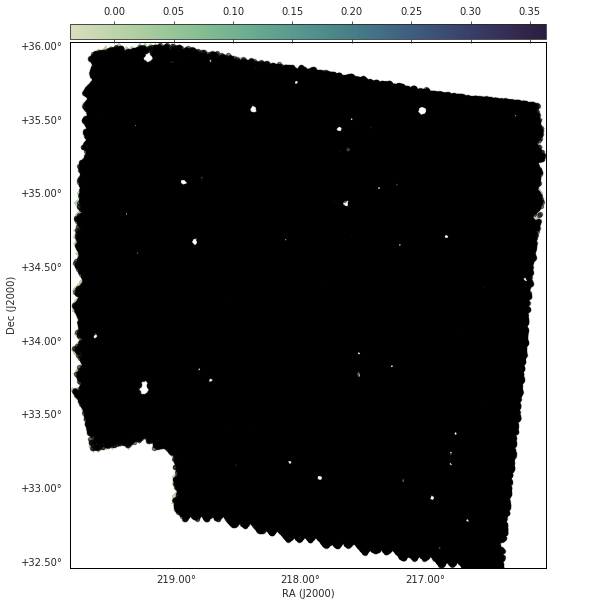

In [27]:
xidplus.plot_map([prior100])

In [31]:
prior100.nsrc

471516

In [25]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [26]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 11341 tiles required for input catalogue and 21 large tiles


SystemExit: 